In [181]:
import warnings
warnings.filterwarnings('ignore')

# Display
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import display

# Image
from PIL import Image
import cv2

# Utils
import os
import requests
from io import BytesIO
import numpy as np

# DL
from keras.models import Model, load_model

In [152]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

#Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    
    return iou

def fetch_image(parameters):
    url = "http://dev.virtualearth.net/REST/v1/Imagery/Map/Aerial/{lat},{lng}/{zoom_level}?mapSize={image_size_x},{image_size_y}&key=AiyDjHyCl1JfMq9cNqM4kZTgSUQ_fhT1MfHq-jteJCnx6OeQ7JHFZgY8lK-hjeF-"
    response = requests.get(url.format(**parameters))
    return np.array(Image.open(BytesIO(response.content)))

def make_crops(image):

        cropped_images = []
        for r in range(0, image.shape[0], 256):
            for c in range(0, image.shape[1], 256):
                blank_image = np.zeros((256 ,256, 3), dtype = int)
                new_image = np.array(image[r:r+256, c:c+256,:])
                blank_image[:new_image.shape[0], :new_image.shape[1], :] += new_image
                cropped_images.append(blank_image)
                
        return cropped_images

def stitch(images):
    blank_image = np.zeros((1500img ,1500, 3), dtype = float)
    counter = 0
    for r in range(0, 1080, 256):
        for c in range(0, 1920, 256):
            
            row, col, _ = blank_image[r:r+256, c:c+256,:].shape
            if counter == len(images): break
            blank_image[r:r+256, c:c+256,:] += images[counter][:row, :col,:]
            counter += 1
    return blank_image


In [165]:
build_model = load_model("../Models/buildings.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef, 'dice_coef_loss':dice_coef})
road_model = load_model("../Models/road_mapper_final.h5", custom_objects={'dice_loss': soft_dice_loss, 'iou_coef': iou_coef, 'dice_coef_loss':dice_coef})

36/36 [==============================] - 5s 127ms/step


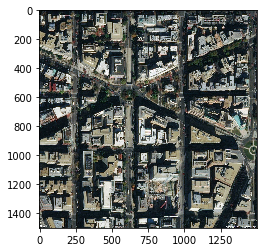

In [189]:
parameters = {"lat": 38.906557,
              "lng": -77.035851,
              "image_size_x":1500,
              "image_size_y":1500, 
              "zoom_level":18}
image = fetch_image(parameters)
cropped_images = make_crops(image)

road_predictions = road_model.predict([cropped_images], verbose=1)
building_predictions = build_model.predict([cropped_images], verbose=1)

stitched_road_predictions = stitch(road_predictions)
stitched_building_predictions = stitch(building_predictions)

plt.imshow(image)

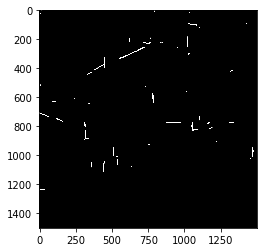

In [191]:
plt.imshow(stitched_road_predictions)

In [197]:
stitched_road_predictions[stitched_road_predictions>[0,0,0]] = [255, 255,0]
plt.imshow(stitched_road_predictions)

ValueError: NumPy boolean array indexing assignment cannot assign 3 input values to the 5384799 output values where the mask is true